## Mass-Spring-Damper System: A Classical Mechanical System

![Mass-Spring-Damper System](./images/Mass_spring_damper.png)

The system encompasses:

- **Mass (m):** Resisting acceleration, this component is influenced by external forces.
- **Spring (k):** A force proportional to the mass's displacement from equilibrium is exerted by this component.
- **Damper (c):** Opposing the mass's motion, this component provides a force proportional to its velocity.

When the mass is displaced and then released, oscillations occur around its equilibrium due to the spring's restoring force and the damper's resistance. 

### Deriving the State-Space Model

**Physical Equations:**  
Starting with Newton's second law: 
$$ F = ma $$

The external force \( F \) is counteracted by the spring and damping forces, thus:
$$ F_{\text{external}} - kx - cv = ma $$

Where:

- Hooke's law, with x as displacement $$ F_{\text{spring}} = kx $$
- v is the velocity $$ F_{\text{damper}} = cv $$

**State Variables:**  
Choosing:
- Displacement $$ x_1 = x $$  
- Velocity $$ x_2 = v $$

Their derivatives:
$$ \dot{x}_1 = x_2 $$
$$ \dot{x}_2 = a $$

Substituting these into our derived equations, we can represent the system in state-space form:

$$ \begin{align*}
\dot{x} &= Ax + Bu \\
y &= Cx + Du \\
\end{align*} $$

Where:  
$$ A = \begin{bmatrix} 0 & 1 \\ -\frac{k}{m} & -\frac{c}{m} \end{bmatrix} $$
$$ B = \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} $$
$$ C = \begin{bmatrix} 1 & 0 \end{bmatrix} $$
$$ D = \begin{bmatrix} 0 \end{bmatrix} $$

## Simulation Overview

In this simulation, we aim to understand the behavior and dynamics of the Mass-Spring-Damper system under various conditions, utilizing a neural network model to emulate its behavior given certain inputs and initial states.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Model definition
First we need to define the system matrices of the state-space model. This is a continuous-time model, we will simulate it using the backwar Euler method.

Physical parameters

In [2]:
m = 100.0  # mass (kg)
c = 0.1  # damping coefficient (N.s/m)
k = 1.0  # spring constant (N/m)

State-space representation

In [3]:
A = np.matrix([[0,1], [-k/m, -c/m]])
B = np.matrix([[0],[1/m]])
C = np.matrix([[1, 0]])

Time and sampling

In [4]:
time=1000
sampling=2

### Data Generation

In [ ]:
from backward_euler import simulate

def generate_data(A, B, C, time, sampling, input_range=(-1, 1)):
    """Generate training, validation, and test data."""

    # Create a new random input sequence and a new random initial condition
    # Use np.random.randn for a normal distribution and then scale and shift it
    input_seq = np.random.randn(time, 1) * (input_range[1] - input_range[0]) / 2 + (input_range[1] + input_range[0]) / 2
    x0 = np.random.randn(2, 1) * (input_range[1] - input_range[0]) / 2 + (input_range[1] + input_range[0]) / 2

    # Add random noise to the input sequence
    noise_strength = 0.05  # Adjust this value to increase or decrease the noise strength
    input_seq += np.random.randn(time, 1) * noise_strength

    # Simulate the system
    state, output = simulate(A, B, C, x0, input_seq, time, sampling)
    output = output.T
    output = np.reshape(output, (1, output.shape[0], 1))

    # Reshape input sequence
    input_seq = np.reshape(input_seq, (input_seq.shape[0], 1))
    tmp = np.concatenate((input_seq, np.zeros(shape=(input_seq.shape[0], 1))), axis=1)
    tmp = np.concatenate((x0.T, tmp), axis=0)

    # This is the input data used for the respective dataset
    inputX = np.reshape(tmp, (1, tmp.shape[0], tmp.shape[1]))

    return inputX, output

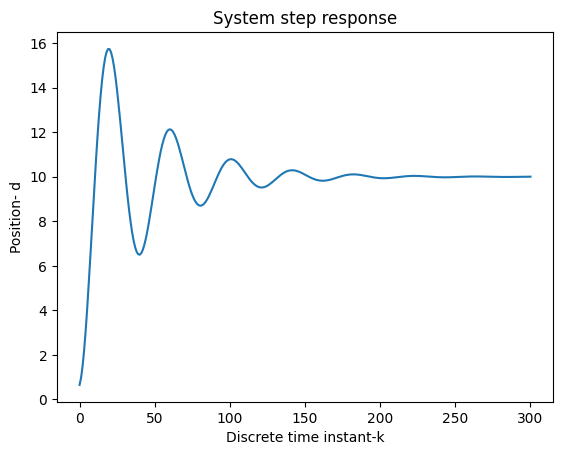

In [5]:
trainX, output_train = generate_data(A, B, C, time, sampling)
validateX, output_validate = generate_data(A, B, C, time, sampling)
testX, output_test = generate_data(A, B, C, time, sampling)

### Network Definition

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.optimizers import RMSprop
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

In [18]:
model=Sequential()
#model.add(SimpleRNN(32, input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
#model.add(GRU(32, input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(LSTM(32, input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(Dense(1))
model.add(TimeDistributed(Dense(1)))  #there is no difference between this and model.add(Dense(1))...
# does not make sense to use metrics=['acc'], see https://stackoverflow.com/questions/41819457/zero-accuracy-training-a-neural-network-in-keras
model.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mse'])

In [ ]:
# after every epoch, we save the model, this is the absolute path on my C: drive, so the path is
# C:\python_files\system_identification\models\
filepath="models/weights-{epoch:02d}-{val_loss:.6f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
callbacks_list = [checkpoint]
history=model.fit(trainX, output_train , epochs=2000, batch_size=1, callbacks=callbacks_list, validation_data=(validateX,output_validate), verbose=2)

### Model Predictions

In [9]:
import os

def get_best_model_path(models_dir="models"):
    """
    Get the path of the model with the smallest validation loss.
    
    Assumes model filenames are in the format "weights-{epoch:02d}-{val_loss:.6f}.hdf5".
    """
    # List all files in the models directory
    files = os.listdir(models_dir)
    
    # Filter out files that don't match the expected pattern
    valid_files = [f for f in files if f.startswith("weights-") and f.endswith(".hdf5")]
    
    # Extract validation loss from each valid filename and get the filename with the minimum loss
    best_file = min(valid_files, key=lambda x: float(x.split('-')[2].split('.hdf5')[0]))
    print(best_file)

    return os.path.join(models_dir, best_file)

In [14]:
# load the model with the smallest validation loss
best_model_path = get_best_model_path()
model.load_weights(best_model_path)

#model.load_weights("weights-1997-1.878475.hdf5")

# use the test data to predict the model response
testPredict = model.predict(testX)

weights-1279-3.757290.hdf5
1/1 [==============================] - 0s 126ms/step


### Result Evaluation

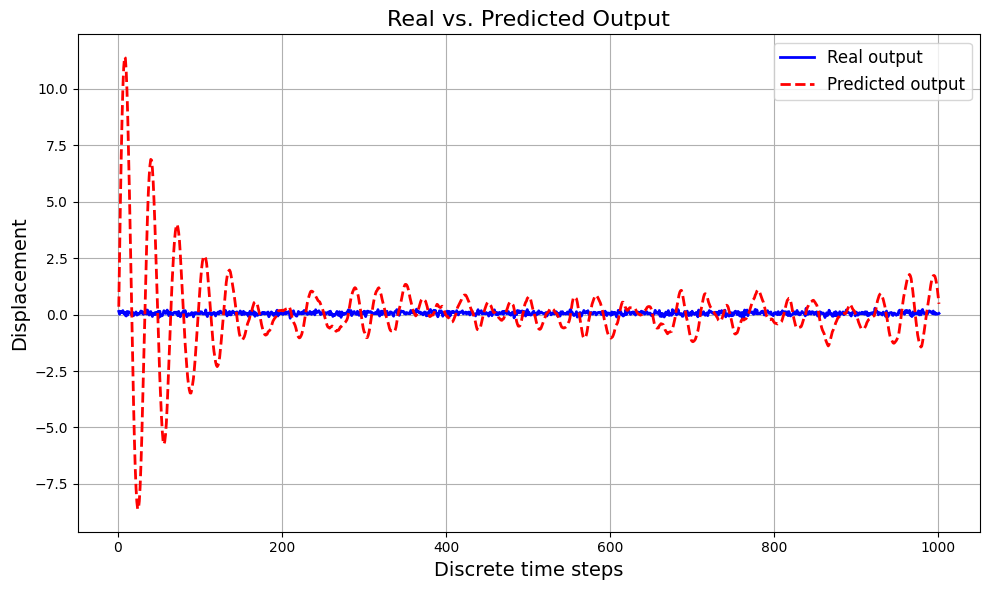

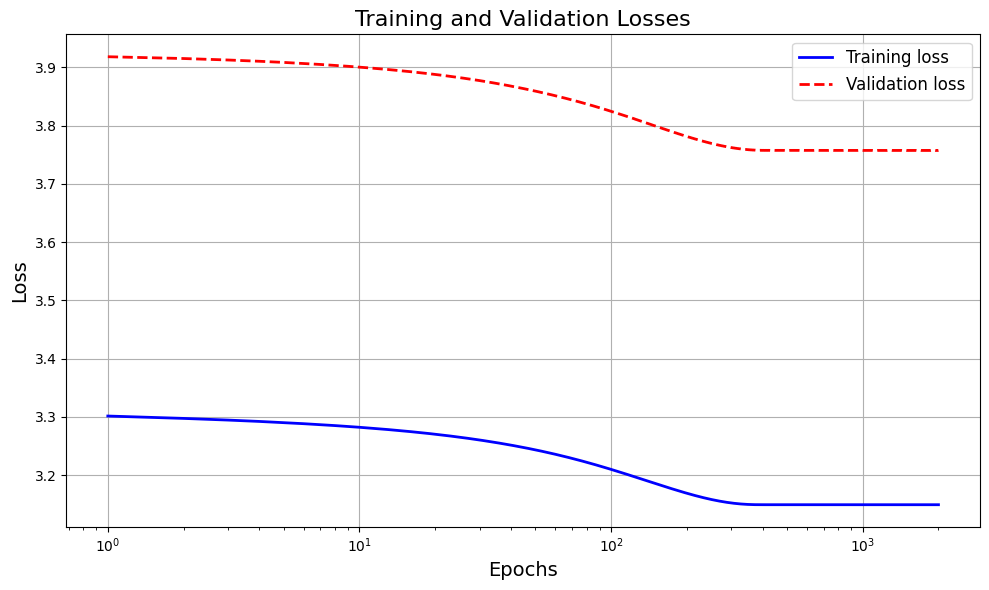

In [15]:
# Plotting the Model Predictions
time_plot = range(1, time + 2)

plt.figure(figsize=(10, 6))
plt.plot(time_plot, testPredict[0, :], 'b-', linewidth=2, label='Real output')
plt.plot(time_plot, output_test[0, :, 0], 'r--', linewidth=2, label='Predicted output')
plt.xlabel('Discrete time steps', fontsize=14)
plt.ylabel('Displacement', fontsize=14)
plt.title('Real vs. Predicted Output', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('./images/responseLSTM32.png')
plt.show()

# Plotting the Training and Validation Losses
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b-', linewidth=2, label='Training loss')
plt.plot(epochs, val_loss, 'r--', linewidth=2, label='Validation loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Losses', fontsize=16)
plt.xscale('log')
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('./images/lossLSTM32.png')
plt.show()
